In [1]:
import json

cookings = json.loads(open('cooking_train.json').read())
cookings[:1]

[{'cuisine': 'greek',
  'id': 10259,
  'ingredients': ['romaine lettuce',
   'black olives',
   'grape tomatoes',
   'garlic',
   'pepper',
   'purple onion',
   'seasoning',
   'garbanzo beans',
   'feta cheese crumbles']}]

In [2]:
ingredients_dict = dict()
regions = list()

for c in cookings:
    regions.append(c['cuisine'])
    for i in c['ingredients']:
        ingredients_dict[i] = ingredients_dict[i] + 1 if i in ingredients_dict else 1
        
regions = list(set(regions))
ingredients = list(ingredients_dict.keys())
ingredients = list(reversed(sorted(ingredients, key=lambda x: ingredients_dict[x])))

len(ingredients), len(regions)

(6714, 20)

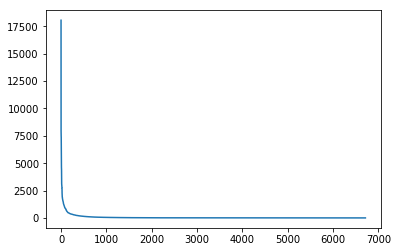

In [3]:
import matplotlib.pyplot as plt

plt.plot(list(reversed(sorted(ingredients_dict.values()))))
plt.show()

In [4]:
for i in range(20):
    print(i * 100, ingredients_dict[ingredients[i * 100]])

0 18049
100 841
200 387
300 268
400 192
500 144
600 110
700 86
800 69
900 58
1000 49
1100 42
1200 36
1300 31
1400 27
1500 24
1600 21
1700 19
1800 17
1900 15


In [5]:
ingredients = ingredients[:2000]

In [6]:
import numpy as np

cookings_ins = list()
cookings_regs = list()

for c in cookings:
    cookings_regs.append(regions.index(c['cuisine']))
    
    row = list()
    for i in ingredients:
        row.append(1 if i in c['ingredients'] else 0)
    row.append(len(ingredients))
    row_arr = np.array(row, dtype=np.int8)
    del row
    
    cookings_ins.append(row_arr)

cookings_ins_arr = np.array(cookings_ins)
cookings_regs_arr = np.array(cookings_regs, dtype=np.int8)

del cookings_ins
del cookings_regs

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(cookings_ins_arr, cookings_regs_arr, test_size=0.33, random_state=777)
print(X_train.shape, y_train.shape)

(26648, 2001) (26648,)


In [8]:
import tensorflow as tf
tf.reset_default_graph() 

regularization = 0.005
nb_classes = len(regions)

keep_prob = tf.placeholder(tf.float32)
X = tf.placeholder(tf.float32, [None, X_train.shape[1]])
Y = tf.placeholder(tf.uint8, [None])
Y_one_hot = tf.one_hot(Y, nb_classes)
Y_one_hot = tf.reshape(Y_one_hot, [-1, nb_classes])
                             
W1 = tf.get_variable(shape=[X_train.shape[1], 512], name='weight1', initializer=tf.contrib.layers.xavier_initializer())
b1 = tf.Variable(tf.random_normal([512]), name='bias1')
L1 = tf.nn.relu(tf.matmul(X, W1) + b1)
L1 = tf.nn.dropout(L1, keep_prob=keep_prob)

W2 = tf.get_variable(shape=[512, 512], name='weight2', initializer=tf.contrib.layers.xavier_initializer())
b2 = tf.Variable(tf.random_normal([512]), name='bias2')
L2 = tf.nn.relu(tf.matmul(L1, W2) + b2)
L2 = tf.nn.dropout(L2, keep_prob=keep_prob)

W3 = tf.get_variable(shape=[512, 512], name='weight3', initializer=tf.contrib.layers.xavier_initializer())
b3 = tf.Variable(tf.random_normal([512]), name='bias3')
L3 = tf.nn.relu(tf.matmul(L2, W3) + b3)
L3 = tf.nn.dropout(L3, keep_prob=keep_prob)

W4 = tf.get_variable(shape=[512, 512], name='weight4', initializer=tf.contrib.layers.xavier_initializer())
b4 = tf.Variable(tf.random_normal([512]), name='bias4')
L4 = tf.nn.relu(tf.matmul(L3, W4) + b4)
L4 = tf.nn.dropout(L4, keep_prob=keep_prob)

W5 = tf.get_variable(shape=[512, nb_classes], name='weight5', initializer=tf.contrib.layers.xavier_initializer())
b5 = tf.Variable(tf.random_normal([nb_classes]), name='bias5')

hypothesis = tf.matmul(L4, W5) + b5

regularizers = tf.nn.l2_loss(W1) + tf.nn.l2_loss(W2) + tf.nn.l2_loss(W3) + tf.nn.l2_loss(W4) + tf.nn.l2_loss(W5) +\
    tf.nn.l2_loss(b1) + tf.nn.l2_loss(b2) + tf.nn.l2_loss(b3) + tf.nn.l2_loss(b4) + tf.nn.l2_loss(b5)
    
cost_i = tf.nn.softmax_cross_entropy_with_logits(logits=hypothesis, labels=Y_one_hot)
cost = tf.reduce_mean(cost_i)
cost = tf.reduce_mean(cost + regularization * regularizers)

optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(cost)

is_correct = tf.equal(tf.argmax(hypothesis, 1), tf.argmax(Y_one_hot, 1))
is_correct = tf.cast(is_correct, tf.float32)
accuracy = tf.reduce_mean(is_correct)

In [9]:
import random

sess=tf.Session()
sess.run(tf.global_variables_initializer())

for step in range(1, 5001):
    sess.run(optimizer, feed_dict={X: X_train, Y: y_train, keep_prob: 0.8})
    if step % 100 == 0:
        print(
              step,
              sess.run(cost, feed_dict={X: X_train, Y: y_train, keep_prob: 0.8}),
              sess.run(accuracy, feed_dict={X: X_train, Y: y_train, keep_prob: 1.0}),
              sess.run(accuracy, feed_dict={X: X_test, Y: y_test, keep_prob: 1.0})
             )

100 7.1863 0.565558 0.559576
200 5.80396 0.701929 0.664178
300 5.02914 0.744859 0.685205
400 4.5153 0.76167 0.682843
500 3.97648 0.823363 0.700823
600 3.58896 0.880553 0.706384
700 3.31909 0.880854 0.701813
800 2.96352 0.930951 0.713927
900 2.73868 0.948626 0.714003
1000 2.54015 0.952604 0.715069
1100 2.35029 0.965363 0.715603
1200 2.58289 0.852221 0.699147
1300 2.08087 0.971555 0.718879
1400 1.98863 0.967464 0.712174
1500 2.02551 0.912526 0.718345
1600 1.804 0.968477 0.719107
1700 1.72811 0.972305 0.71926
1800 1.64815 0.977972 0.718193


KeyboardInterrupt: 